In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.spatial.distance import euclidean
from sklearn.preprocessing import StandardScaler

from imputers import KNNImputerMode, KNNImputerMedian

In [2]:
data = pd.read_csv('./Financial Well-Being Survey Data/NFWBS_PUF_2016_data.csv')

print(f'The dataset contains {data.shape[0]} rows and {data.shape[1]} features.')

The dataset contains 6394 rows and 217 features.


In [3]:
data.duplicated().sum()

0

# Data cleaning

In [4]:
data.set_index('PUF_ID', inplace=True)

## Dropping irrelevant features

We can remove features that were used for feature engineering

Engineered features: 
- FWBScore: created from FWB questions
- FSscore: created from FS questions
- LMscore: created from FINKKNOWL questions + FKcorrect
- KHscore: created from KHKNOWL questions + KHcorrect
- ON1correct: OBJNUMERACY1
- ON2correct: OBJNUMERACY2

In [5]:
FWB_cols = list(filter(lambda x: 'FWB' in x, data.columns.values))
FWB_drop = FWB_cols[1:]
data.drop(FWB_drop, axis = 1, inplace = True)

list(filter(lambda x: 'FWB' in x, data.columns.values))

['FWBscore']

In [6]:
FS_cols = list(filter(lambda x: 'FS' in x, data.columns.values))
FS_cols = FS_cols[1:]
data.drop(FS_cols, axis = 1, inplace = True)

list(filter(lambda x: 'FS' in x, data.columns.values))

['FSscore']

In [7]:
LM_cols = list(filter(lambda x: 'FINKNOWL' in x, data.columns.values))

data.drop(LM_cols, axis = 1, inplace = True)

list(filter(lambda x: 'FINKNOWL' in x, data.columns.values))

[]

In [8]:
FKcorrect_cols = ['FK1correct', 'FK2correct', 'FK3correct']

data.drop(FKcorrect_cols, axis = 1, inplace = True)

In [9]:
KH_cols = list(filter(lambda x: 'KHKNOWL' in x, data.columns.values))

data.drop(KH_cols, axis = 1, inplace = True)

list(filter(lambda x: 'KHKNOWL' in x, data.columns.values))

[]

In [10]:
KHcorrect_cols = ['KH1correct', 'KH2correct', 'KH3correct', 'KH4correct', 'KH5correct', 'KH6correct', 'KH7correct', 'KH8correct', 'KH9correct']

data.drop(KHcorrect_cols, axis = 1, inplace = True)

In [11]:
OBJNUMcols = list(filter(lambda x: 'OBJNUMERACY' in x, data.columns.values))

data.drop(OBJNUMcols, axis = 1, inplace = True)

list(filter(lambda x: 'OBJNUMERACY' in x, data.columns.values))

[]

In [12]:
data.head()

,sample,fpl,SWB_1,SWB_2,SWB_3,FWBscore,FSscore,SUBKNOWL1,ACT1_1,ACT1_2,...,PPMSACAT,PPREG4,PPREG9,PPT01,PPT25,PPT612,PPT1317,PPT18OV,PCTLT200FPL,finalwt
PUF_ID,,,,,,,,,,,,,,,,,,,,,
10350,2,3,5,5,6,55,44,5,4,3,...,1,4,8,0,0,0,0,1,0,0.367292
7740,1,3,6,6,6,51,43,5,4,3,...,1,2,3,0,0,0,0,2,0,1.327561
13699,1,3,4,3,4,49,42,5,3,3,...,1,4,9,0,0,0,1,2,1,0.835156
7267,1,3,6,6,6,49,42,-1,-1,-1,...,1,3,7,0,0,0,0,1,0,1.410871
7375,1,3,4,4,4,49,42,4,3,3,...,1,2,4,0,0,1,0,4,1,4.260668


## Missing values

## __-5: County not known__


Use PPREG9, PPINCIMP and PPEDUC to impute PCTLT200FPL

PPEDUC: ordinal
<br>
PPINCIMP: ordinal
<br>
PPREG9: categorical

distance to find nearest neighbors: euclidean for PPINC, PPEDUC  + one hot for PPREG9

In [13]:
# replace by missing values
data = data.replace(-5, np.nan)

In [14]:
nrows = data[data['PCTLT200FPL'].isna()].shape[0]
print(f'nr of rows with missing value: {nrows}')

nr of rows with missing value: 395


In [15]:
def distance(X, Y, missing_values = np.nan):
    
    X[np.isnan(X)] = 0
    Y[np.isnan(Y)] = 0

    eucl_dist = euclidean(X[[0, 1]], Y[[0, 1]])

    return eucl_dist + (X[2] != Y[2])

In [18]:
imputer = KNNImputerMode(n_neighbors = 5, metric = distance)

cols = ['PPEDUC', 'PPINCIMP', 'PPREG9', 'PCTLT200FPL']

# scale numerical features
scaler = StandardScaler()
scaled_data = scaler.fit_transform(data[['PPEDUC', 'PPINCIMP']])
scaled_data = pd.DataFrame(scaled_data, columns = ['PPEDUC', 'PPINCIMP'], index = data.index)
# join with other columns
scaled_data = pd.concat([scaled_data, data[['PPREG9', 'PCTLT200FPL']]], axis = 1)

new_data = imputer.fit_transform(scaled_data)

new_data = pd.DataFrame(new_data, columns = cols, index = data.index)

In [21]:
new_data['PCTLT200FPL'].value_counts()

0.0    4849
1.0    1545
Name: PCTLT200FPL, dtype: int64

In [22]:
data.loc[data['PCTLT200FPL'].isna(), 'PCTLT200FPL'] = new_data.loc[data['PCTLT200FPL'].isna(), 'PCTLT200FPL'].copy()

## __-4: Response not written to the database due to error__

SWB only (because FWB dropped) ->DROP

In [258]:
data[(data == -4).any(axis = 1)]

,sample,fpl,SWB_1,SWB_2,SWB_3,FWBscore,FSscore,SUBKNOWL1,ACT1_1,ACT1_2,...,PPMSACAT,PPREG4,PPREG9,PPT01,PPT25,PPT612,PPT1317,PPT18OV,PCTLT200FPL,finalwt
PUF_ID,,,,,,,,,,,,,,,,,,,,,
12173,1,3,-4,-4,-4,-4,48,7,4,3,...,1,3,5,0,0,0,0,1,0.0,1.253964


In [259]:
data.drop(12173, axis = 0, inplace = True)

## __-3: Invalid response/ Incoherent data__

- Drop the only row with KIDS_2 = -3
- Replace -3 with -2 for SOCSEC2 because -3 are caused by invalid age, therefore -2 is the adequate label.
- Replace -3 with the mode for SOCSEC3

KIDS_2 drop

In [260]:
data[data['KIDS_2'] == -3]

,sample,fpl,SWB_1,SWB_2,SWB_3,FWBscore,FSscore,SUBKNOWL1,ACT1_1,ACT1_2,...,PPMSACAT,PPREG4,PPREG9,PPT01,PPT25,PPT612,PPT1317,PPT18OV,PCTLT200FPL,finalwt
PUF_ID,,,,,,,,,,,,,,,,,,,,,
13237,1,2,3,7,7,52,50,5,4,4,...,1,2,3,0,0,1,1,3,0.0,1.690435


In [261]:
data.drop(13237, axis = 0, inplace = True)

SOCSEC2

In [262]:
valid_data = data[(data['SOCSEC1'] == 1) & (data['SOCSEC2'] != -1) & ((data['SOCSEC2'] != -3))]

In [263]:
data.loc[data['SOCSEC2'] == -3, 'SOCSEC2'] = valid_data['SOCSEC2'].mode()[0]

In [264]:
data['SOCSEC2'].value_counts()

-2     4526
 62     905
 65     459
 66     159
 63     130
 64      68
 67      55
 70      51
 68      19
-1       12
 69       8
Name: SOCSEC2, dtype: int64

SOCSEC3

In [265]:
data.loc[data['SOCSEC3'] == -3, 'agecat'].value_counts()

4    25
3    15
2    14
5    11
1     3
Name: agecat, dtype: int64

In [266]:
data.loc[data['SOCSEC3'] >= 61, 'agecat'].value_counts()

2    1056
4    1027
3     782
5     679
1     387
Name: agecat, dtype: int64

In [267]:
valid_data = data[data['agecat'] <= 5]

In [268]:
data.loc[data['SOCSEC3'] == -3, 'SOCSEC3'] = valid_data['SOCSEC3'].mode()[0]

In [269]:
data['SOCSEC3'].value_counts()

-2     2253
 65    1289
 70     723
 67     451
 61     406
 62     372
 71     364
 68     160
-1      140
 66     118
 63      51
 69      41
 64      24
Name: SOCSEC3, dtype: int64

## Others
__-1: Not answered/ Left blank__
<br>
__98: Don't know__
<br>
__99: Prefer not to say__

First, let's replace the missing values with NaN

In [270]:
data = data.replace(-1, np.nan)
data[['HOUSERANGES', 'VALUERANGES', 'MORTGAGE', 'SAVINGSRANGES']] = data[['HOUSERANGES', 'VALUERANGES', 'MORTGAGE', 'SAVINGSRANGES']].replace(98, np.nan)
data[['HOUSERANGES', 'VALUERANGES', 'MORTGAGE', 'SAVINGSRANGES']] = data[['HOUSERANGES', 'VALUERANGES', 'MORTGAGE', 'SAVINGSRANGES']].replace(99, np.nan)

In [271]:
data[data.isna().sum(axis = 1) >= 5]

,sample,fpl,SWB_1,SWB_2,SWB_3,FWBscore,FSscore,SUBKNOWL1,ACT1_1,ACT1_2,...,PPMSACAT,PPREG4,PPREG9,PPT01,PPT25,PPT612,PPT1317,PPT18OV,PCTLT200FPL,finalwt
PUF_ID,,,,,,,,,,,,,,,,,,,,,
7267,1,3,6.0,6.0,6.0,49.0,42.0,NaN,NaN,NaN,...,1,3,7,0,0,0,0,1,0.0,1.410871
8303,1,3,7.0,7.0,7.0,43.0,58.0,4.0,3.0,3.0,...,1,3,7,0,0,0,1,3,0.0,2.497838
9182,1,3,6.0,NaN,NaN,50.0,43.0,4.0,4.0,3.0,...,1,4,9,0,0,0,0,2,0.0,0.647301
11082,1,3,6.0,6.0,5.0,62.0,55.0,4.0,5.0,4.0,...,1,3,5,0,0,0,0,3,0.0,0.455829
8309,2,3,3.0,4.0,2.0,49.0,37.0,NaN,4.0,3.0,...,1,3,5,0,0,0,0,1,0.0,0.597089
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13222,3,2,7.0,7.0,7.0,40.0,45.0,4.0,3.0,2.0,...,1,3,7,0,0,0,0,4,0.0,1.232251
11078,3,1,3.0,4.0,5.0,26.0,44.0,4.0,3.0,3.0,...,1,2,3,0,1,0,0,1,0.0,1.379959
12353,1,3,5.0,7.0,3.0,62.0,26.0,4.0,3.0,3.0,...,1,3,5,0,0,0,0,2,0.0,1.745759


Now let's drop the rows with more than 5 missing values

In [272]:
data.drop(data[data.isna().sum(axis = 1) >= 5].index, axis = 0, inplace = True)

In [273]:
data.shape

(6054, 171)

Now, let's see which columns have missing values

In [274]:
data.isna().sum(axis = 0).index

Index(['sample', 'fpl', 'SWB_1', 'SWB_2', 'SWB_3', 'FWBscore', 'FSscore',
       'SUBKNOWL1', 'ACT1_1', 'ACT1_2',
       ...
       'PPMSACAT', 'PPREG4', 'PPREG9', 'PPT01', 'PPT25', 'PPT612', 'PPT1317',
       'PPT18OV', 'PCTLT200FPL', 'finalwt'],
      dtype='object', length=171)

And how many missing values per column

In [275]:
# how many missing values per column that has missing values
data.isna().sum(axis = 0)[data.isna().sum(axis = 0) > 0]

SWB_1              13
SWB_2              37
SWB_3              39
SUBKNOWL1          34
ACT1_1             14
                   ..
KIDS_3              1
KIDS_4              7
RETIRE              2
MILITARY           16
Military_Status    32
Length: 78, dtype: int64

Get all columns with less than 100 missing values

In [276]:
# get all columns with less than 100 missing values

data.isna().sum(axis = 0)[(data.isna().sum(axis = 0) > 0) & (data.isna().sum(axis = 0) < 100)].index

Index(['SWB_1', 'SWB_2', 'SWB_3', 'SUBKNOWL1', 'ACT1_1', 'ACT1_2', 'FINGOALS',
       'SAVEHABIT', 'FRUGALITY', 'AUTOMATED_1', 'AUTOMATED_2', 'ASK1_1',
       'ASK1_2', 'SUBNUMERACY2', 'SUBNUMERACY1', 'CHANGEABLE', 'GOALCONF',
       'ENDSMEET', 'HOUSING', 'LIVINGARRANGEMENT', 'CONSPROTECT1',
       'CONSPROTECT2', 'CONSPROTECT3', 'EARNERS', 'VOLATILITY', 'SNAP',
       'MATHARDSHIP_6', 'COLLECT', 'REJECTED_1', 'REJECTED_2', 'ABSORBSHOCK',
       'BENEFITS_3', 'BENEFITS_4', 'BENEFITS_5', 'FRAUD2', 'COVERCOSTS',
       'MANAGE2', 'PAIDHELP', 'PAREDUC', 'FINSOC2_3', 'FINSOC2_5', 'FINSOC2_6',
       'MATERIALISM_1', 'MATERIALISM_2', 'MATERIALISM_3', 'HEALTH',
       'SCFHORIZON', 'DISCOUNT', 'MEMLOSS', 'DISTRESS', 'SELFCONTROL_1',
       'SELFCONTROL_2', 'SELFCONTROL_3', 'OUTLOOK_1', 'OUTLOOK_2', 'PEM',
       'HOUSESAT', 'SOCSEC1', 'SOCSEC2', 'SOCSEC3', 'LIFEEXPECT', 'HHEDUC',
       'KIDS_1', 'KIDS_2', 'KIDS_3', 'KIDS_4', 'RETIRE', 'MILITARY',
       'Military_Status'],
      dtype='obj

In [277]:
data.isna().sum(axis = 0)[data.isna().sum(axis = 0) > 100].index

Index(['HOUSERANGES', 'VALUERANGES', 'MORTGAGE', 'SAVINGSRANGES', 'BORROW_1',
       'BORROW_2', 'HSLOC', 'CONNECT', 'KIDS_NoChildren'],
      dtype='object')

__Central tendency imputations__

Given the large size of the dataset, for columns with less than 100 missing values we will use measures of central tendency:

__Ordinal__

SWB_1, SWB_2, SUBKNOWL1, ACT1_2, ASK1_1, SUBNUMERACY1, LIVINGARRANGEMENT, CONSPROTECT1, ABSORBSHOCK, PAREDUC, MATERIALISM_3, HEALTH, SELFCONTROL_1, SELFCONTROL_2, SELFCONTROL_3, OUTLOOK_1, OUTLOOK_2, PEM: skewed -> median

SWB_3, ACT1_1, SAVEHABIT, FRUGALITY, ENDSMEET, CONSPROTECT2, MATHARDSHIP_6, HOUSESAT: staricase -> mode

AUTOMATED_1, AUTOMATED_2, ASK1_2, SUBNUMERACY2, CHANGEABLE, GOALCONF, EARNERS, MATERIALISM,_1, MATERIALISM_2, SCFHORIZON, DISTRESS, HHEDUC, EMPLOY, RETIRE (cuidado com -2): gaussian distribution -> mode

__Categorical__

FINGOALS, AUTOMATED_2, HOUSING, CONSPROTECT3, VOLATILITY, SNAP, COLLECT, REJECTED_1, REJECTED_2, BENEFITS_3, BENEFITS_4, BENEFITS_5, FRAUD2, COVERCOSTS, MANAGE2, PAIDHELP (cuidado com -2), FINSOC2_3, FINSOC2_5, FINSOC2_6, DISCOUNT, MEMLOSS, SOCSEC1, SOCSEC2, SOCSEC3 (cuidado com -3 e -2), KIDS_1, KIDS_2, KIDS_3, KIDS_4, EMPLOY, MILITARY, Military_Status: mode

In [278]:
data.loc[data['SOCSEC1'].isna(), ['SOCSEC1', 'SOCSEC2', 'SOCSEC3']] # just drop because is almost impossible to know and has implications on two more answers

,SOCSEC1,SOCSEC2,SOCSEC3
PUF_ID,,,
10357,NaN,-2.0,-2.0
11275,NaN,-2.0,-2.0
13281,NaN,-2.0,-2.0


In [279]:
data.drop(data[data['SOCSEC1'].isna()].index, axis = 0, inplace = True)

In [280]:
data.loc[data['SOCSEC2'].isna(), ['SOCSEC1', 'SOCSEC2', 'SOCSEC3']] # take only into consideration

,SOCSEC1,SOCSEC2,SOCSEC3
PUF_ID,,,
14093,1.0,NaN,-2.0
13330,1.0,NaN,-2.0
13604,1.0,NaN,-2.0
13728,1.0,NaN,-2.0
12982,1.0,NaN,-2.0
12470,1.0,NaN,-2.0
11348,1.0,NaN,-2.0


In [281]:
data.loc[data['SOCSEC3'].isna(), ['SOCSEC1', 'SOCSEC2', 'SOCSEC3']] # take only into consideration

,SOCSEC1,SOCSEC2,SOCSEC3
PUF_ID,,,
12163,-2.0,-2.0,NaN
8956,-2.0,-2.0,NaN
11503,-2.0,-2.0,NaN
9207,-2.0,-2.0,NaN
8009,-2.0,-2.0,NaN
7323,-2.0,-2.0,NaN
8135,-2.0,-2.0,NaN
7407,-2.0,-2.0,NaN
13641,-2.0,-2.0,NaN


In [282]:
data.loc[data['SOCSEC3'] != -2, 'SOCSEC3'].value_counts()

65.0    1261
70.0     714
67.0     442
61.0     388
71.0     355
62.0     354
68.0     158
66.0     117
63.0      48
69.0      41
64.0      24
Name: SOCSEC3, dtype: int64

In [283]:
data.loc[data['RETIRE'].isna(), 'EMPLOY']

PUF_ID
13604    8
14063    8
Name: EMPLOY, dtype: int64

In [284]:
data.loc[(data['RETIRE'] >= 1) , 'EMPLOY1_8'].value_counts()

1    1759
Name: EMPLOY1_8, dtype: int64

In [285]:
data.loc[data['HOUSING'].isna(), ['HOUSING', 'VALUERANGES', 'MORTGAGE']] # 12 observations with no infor about housing

# better to drop because VALUERANGES and MORTGAGE depend on this one

,HOUSING,VALUERANGES,MORTGAGE
PUF_ID,,,
13223,NaN,-2.0,-2.0
12313,NaN,-2.0,-2.0
9224,NaN,-2.0,-2.0
12108,NaN,-2.0,-2.0
12606,NaN,-2.0,-2.0
11559,NaN,-2.0,-2.0
13717,NaN,-2.0,-2.0
10458,NaN,-2.0,-2.0
10660,NaN,-2.0,-2.0


In [286]:
data.drop(data[data['HOUSING'].isna()].index, axis = 0, inplace = True)

In [287]:
skewed_ordinal = ['SWB_1', 'SWB_2', 'SUBKNOWL1', 'ACT1_2', 'ASK1_1', 'SUBNUMERACY1', 'CONSPROTECT1', 'ABSORBSHOCK', 'PAREDUC', 'MATERIALISM_3', 'HEALTH', 'SELFCONTROL_1', 'SELFCONTROL_2', 'SELFCONTROL_3', 'OUTLOOK_1', 'OUTLOOK_2', 'PEM']

for feat in skewed_ordinal:
    data.loc[data[feat].isna(), feat] = data[feat].median()

staircase_ordinal = ['SWB_3', 'ACT1_1', 'SAVEHABIT', 'FRUGALITY', 'ENDSMEET', 'CONSPROTECT2', 'MATHARDSHIP_6', 'HOUSESAT']

for feat in staircase_ordinal:
    data.loc[data[feat].isna(), feat] = data[feat].mode()[0]

# excluding RETIRE, SOCSEC2 and SOCSEC3 because it has -2 values
gaussian_ordinal = ['ASK1_2', 'SUBNUMERACY2', 'CHANGEABLE', 'GOALCONF', 'EARNERS', 'MATERIALISM_1', 'MATERIALISM_2', 'SCFHORIZON', 'DISTRESS', 'HHEDUC', 'EMPLOY']

for feat in gaussian_ordinal:
    data.loc[data[feat].isna(), feat] = data[feat].mode()[0]

valid_data = data[data['RETIRE'] >= 1].copy()
data.loc[data['RETIRE'].isna(), 'RETIRE'] = valid_data['RETIRE'].mode()[0]

valid_data = data[data['SOCSEC2'] != -2].copy()
data.loc[data['SOCSEC2'].isna(), 'SOCSEC2'] = valid_data['SOCSEC2'].mode()[0]

valid_data = data[data['SOCSEC3'] != -2].copy()
data.loc[data['SOCSEC3'].isna(), 'SOCSEC3'] = valid_data['SOCSEC3'].mode()[0]

# excluding PAIDHELP, SOCSEC2 and SOCSEC3 because they have -2 values
categorical = ['FINGOALS', 'AUTOMATED_1', 'AUTOMATED_2', 'LIVINGARRANGEMENT','AUTOMATED_2', 'CONSPROTECT3', 'VOLATILITY', 'SNAP', 'COLLECT', 'REJECTED_1', 'REJECTED_2', 'BENEFITS_3', 'BENEFITS_4', 'BENEFITS_5', 'FRAUD2', 'COVERCOSTS', 'MANAGE2', 'FINSOC2_3', 'FINSOC2_5', 'FINSOC2_6', 'DISCOUNT', 'MEMLOSS', 'KIDS_1', 'KIDS_2', 'KIDS_3', 'KIDS_4', 'EMPLOY', 'MILITARY', 'Military_Status']

for feat in categorical:
    data.loc[data[feat].isna(), feat] = data[feat].mode()[0]

valid_data = data[data['PAIDHELP'] != -2].copy()
data.loc[data['PAIDHELP'].isna(), 'PAIDHELP'] = valid_data['PAIDHELP'].mode()[0]


In [288]:
data[skewed_ordinal + gaussian_ordinal + staircase_ordinal + categorical].isna().sum().sum()

0

__Other imputation approaches__

['HOUSERANGES', 'VALUERANGES', 'MORTGAGE', 'SAVINGSRANGES', 'BORROW_1',
       'BORROW_2', 'HSLOC', 'CONNECT', 'LIFEEXPECT', 'KIDS_NoChildren']

__HOUSERANGES__

'About how much do you pay for your home each month?'

Impute with KNNImputer:

FWBscore: numerical
<br>
COLLECT: binary
<br>
ABSORBSHOCK: ordinal
<br>
HOUSING: categorical
<br>
GOALCONF: ordinal
<br>
MANAGE1_3: ordinal
<br>
ENDSMEET: ordinal
<br>
SAVEHABIT: ordinal
<br>
HOUSESAT: ordinal
<br>
PPINCIMP: ordinal

TODO: try age, sex, race, nr of household members

In [289]:
data[data['HOUSERANGES'].isna()].shape[0]

742

In [290]:
def distance(X, Y, missing_values = np.nan):
    X[np.isnan(X)] = 0
    Y[np.isnan(Y)] = 0

    eucl_dist = euclidean(X[[1, 2, 3, 4, 5, 6, 7, 8, 9]], Y[[1, 2, 3, 4, 5, 6, 7, 8, 9]])

    return eucl_dist + (X[0] != Y[0])

In [291]:
imputer = KNNImputerMode(n_neighbors = 5, metric = distance)

cols = ['FWBscore', 'COLLECT', 'ABSORBSHOCK', 'HOUSING', 'GOALCONF', 'MANAGE1_3', 'ENDSMEET', 'SAVEHABIT', 'HOUSESAT', 'PPINCIMP', 'HOUSERANGES']

new_data = imputer.fit_transform(data[cols])

new_data = pd.DataFrame(new_data, columns = cols, index = data.index)

In [292]:
data.loc[data['HOUSERANGES'].isna(), 'HOUSERANGES'] = new_data.loc[data['HOUSERANGES'].isna(), 'HOUSERANGES'].copy()

<AxesSubplot:xlabel='HOUSERANGES', ylabel='count'>

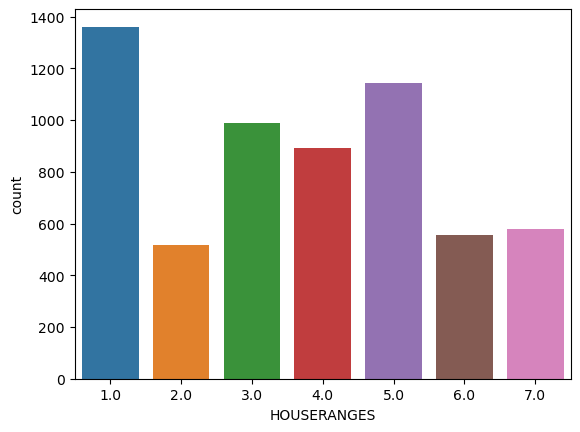

In [293]:
sns.countplot(x = 'HOUSERANGES', data = data)

# the distribution remains similar to the original one before imputation

In [294]:
data['HOUSERANGES'].value_counts()

1.0    1361
5.0    1144
3.0     988
4.0     894
7.0     579
6.0     554
2.0     518
Name: HOUSERANGES, dtype: int64

__VALUERANGES__

'If you were to sell your home today, what do you think it would be worth?'

Impute using KNN:

HOUSERANGES: ordinal
<br>
HOUSESAT: ordinal
<br>
PPINCIMP: ordinal

distance: euclidean

In [295]:
data[data['VALUERANGES'].isna()].shape[0]

175

In [296]:
data.loc[data['HOUSING'] == 1, 'VALUERANGES'].value_counts()

2.0    1017
1.0    1002
3.0     963
4.0     792
Name: VALUERANGES, dtype: int64

In [297]:
valid_data = data[data['VALUERANGES'] != -2]

In [298]:
imputer = KNNImputerMode(n_neighbors = 5)

cols = ['HOUSERANGES', 'HOUSESAT', 'PPINCIMP', 'MORTGAGE', 'VALUERANGES']

new_data = imputer.fit_transform(valid_data[cols])

new_data = pd.DataFrame(new_data, columns = cols, index = valid_data.index)

In [299]:
data.loc[data['VALUERANGES'].isna(), 'VALUERANGES'] = new_data.loc[data['VALUERANGES'].isna(), 'VALUERANGES'].copy()

In [300]:
data['VALUERANGES'].isna().sum()

0

<AxesSubplot:xlabel='VALUERANGES', ylabel='count'>

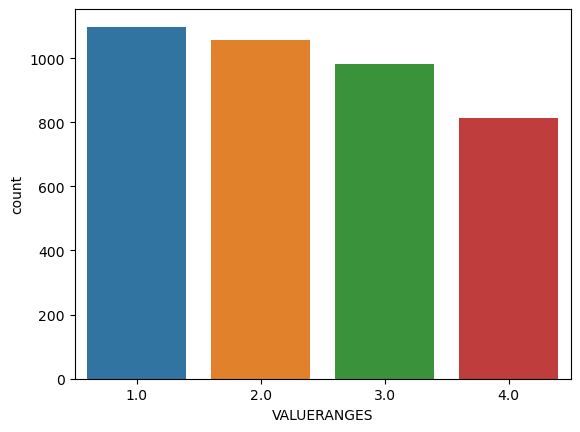

In [301]:
sns.countplot(x = 'VALUERANGES', data = data[data['VALUERANGES'] != -2])

Again, the distribution remains really similar to the original one

__MORTGAGE__

'What do you owe on your home today?'

In [302]:
data[data['MORTGAGE'].isna()].shape[0]

526

In [303]:
valid_data = data[data['MORTGAGE'] != -2]

In [304]:
imputer = KNNImputerMode(n_neighbors = 5)

cols = ['HOUSERANGES', 'PPHHSIZE', 'PPINCIMP', 'VALUERANGES', 'MORTGAGE']

new_data = imputer.fit_transform(valid_data[cols])

new_data = pd.DataFrame(new_data, columns = cols, index = valid_data.index)

In [305]:
data.loc[data['MORTGAGE'].isna(), 'MORTGAGE'] = new_data.loc[data['MORTGAGE'].isna(), 'MORTGAGE'].copy()

<AxesSubplot:xlabel='MORTGAGE', ylabel='count'>

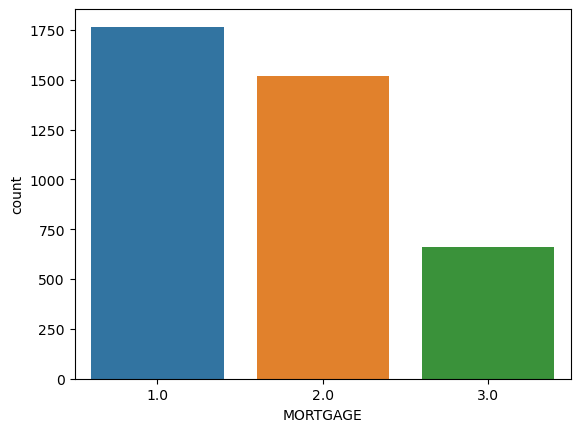

In [306]:
sns.countplot(x = 'MORTGAGE', data = data[data['MORTGAGE'] != -2])

__SAVINGSRANGES__

'How much money do you have in savings today?'

KNN imputation using:

SAVEHABIT: ordinal
<br>
PRODHAVE_1: binary
<br>
MATHARDSHIP_1: ordinal
<br>
COLLECT: ordinal
<br>
PPINCIMP: ordinal

distance: euclidean + hamming

In [307]:
data[data['SAVINGSRANGES'].isna()].shape[0]

947

In [308]:
def distance(X, Y, missing_values = np.nan):
    X[np.isnan(X)] = 0
    Y[np.isnan(Y)] = 0

    eucl_dist = euclidean(X[[0, 2, 3, 4]], Y[[0, 2, 3, 4]])

    return eucl_dist + (X[1] != Y[1])

In [309]:
imputer = KNNImputerMode(n_neighbors = 5, metric = distance)

cols = ['SAVEHABIT', 'PRODHAVE_1', 'MATHARDSHIP_1', 'COLLECT', 'PPINCIMP', 'SAVINGSRANGES']

new_data = imputer.fit_transform(data[cols])

new_data = pd.DataFrame(new_data, columns = cols, index = data.index)

In [310]:
data.loc[data['SAVINGSRANGES'].isna(), 'SAVINGSRANGES'] = new_data.loc[data['SAVINGSRANGES'].isna(), 'SAVINGSRANGES'].copy()

__BORROW_1__

'My friends or family would lend me the money and expect me to repay them'

In [311]:
data[data['BORROW_1'].isna()].shape[0]

111

In [312]:
data.loc[data['BORROW_1'].isna(), 'BORROW_1'] = data['BORROW_1'].mode()[0]

__BORROW_2__

'My friends or family would give me the money with no expectation of'

In [313]:
data[data['BORROW_2'].isna()].shape[0]

207

In [314]:
data.loc[data['BORROW_2'].isna(), 'BORROW_2'] = data['BORROW_2'].mode()[0]

__HSLOC__

'Where did you live at age 17?'

In [315]:
data[data['HSLOC'].isna()].shape[0]

519

In [316]:
data.loc[data['HSLOC'].isna(), 'HSLOC'] = data['HSLOC'].mode()[0]

__CONNECT__

Psychological connectedness

KNN imputation using:

PPINCIMP: ordinal
<br>
DISSTRESS: ordinal
<br>
agecat: ordinal
<br>
CHANGEABLE: ordinal

distance: euclidean

In [317]:
data[data['CONNECT'].isna()].shape[0]

142

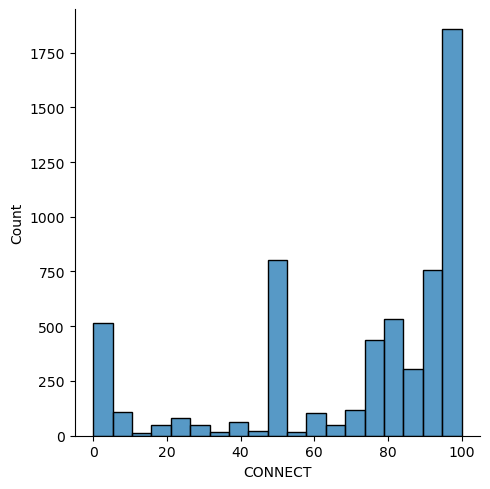

In [318]:
sns.displot(x = 'CONNECT', data = data)

In [319]:
imputer = KNNImputerMedian(n_neighbors = 5)

cols = ['PPINCIMP', 'DISTRESS', 'agecat', 'CHANGEABLE', 'CONNECT']

new_data = imputer.fit_transform(data[cols])

new_data = pd.DataFrame(new_data, columns = cols, index = data.index)

/home/inesmcm/miniconda3/envs/functionalenv/lib/python3.9/site-packages/numpy/core/fromnumeric.py:758: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


In [320]:
data.loc[data['CONNECT'].isna(), 'CONNECT'] = new_data.loc[data['CONNECT'].isna(), 'CONNECT'].copy()

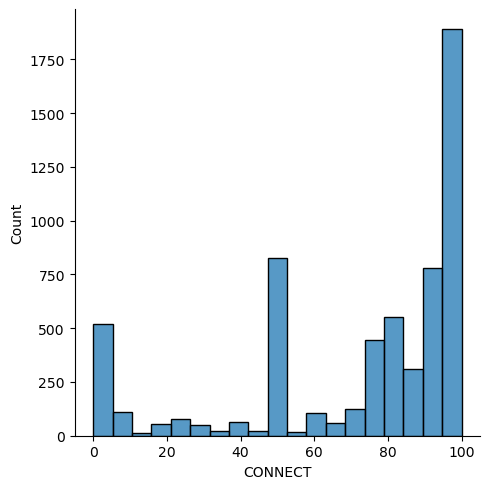

In [321]:
sns.displot(x = 'CONNECT', data = data)

__LIFEEXPECT__


'How likely do you believe it is that you will live beyond age 75?'

KNN Imputation usign variables:

HEALTH: ordinal
<br>
SWB_2: ordinal
<br>
DISTRESS: ordinal

distance: euclidean


In [322]:
data[data['LIFEEXPECT'].isna()].shape[0]

42

In [323]:
data.loc[data['LIFEEXPECT'] >= 0, 'agecat'].value_counts() # 92 people with agecat == 8-> people who are exactly 75 years old

2    1052
4    1025
6     945
3     788
5     672
7     459
1     381
8      99
Name: agecat, dtype: int64

In [324]:
data.loc[data['LIFEEXPECT'].isna(), 'agecat'].value_counts()
# when agecat == 8, age > 75, so let's set probability to the mean of people with agecat == 8

2    15
3     9
6     5
4     5
1     5
5     3
Name: agecat, dtype: int64

In [325]:
round(data.loc[(data['agecat'] == 8) & (data['LIFEEXPECT'] != -2), 'LIFEEXPECT'].mean())

98

In [326]:
data.loc[(data['LIFEEXPECT'].isna()) & (data['agecat'] == 8), 'LIFEEXPECT'] = round(data.loc[(data['agecat'] == 8) & (data['LIFEEXPECT'] != -2), 'LIFEEXPECT'].mean())

In [327]:
data.loc[data['LIFEEXPECT'].isna(), 'agecat'].value_counts()

2    15
3     9
6     5
4     5
1     5
5     3
Name: agecat, dtype: int64

In [328]:
valid_data = data[data['LIFEEXPECT'] != -2]

In [329]:
imputer = KNNImputerMedian(n_neighbors = 5)

cols = ['HEALTH', 'SWB_2', 'DISTRESS', 'LIFEEXPECT']

new_data = imputer.fit_transform(valid_data[cols])

new_data = pd.DataFrame(new_data, columns = cols, index = valid_data.index)

/home/inesmcm/miniconda3/envs/functionalenv/lib/python3.9/site-packages/numpy/core/fromnumeric.py:758: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


In [330]:
data.loc[data['LIFEEXPECT'].isna(), 'LIFEEXPECT'] = new_data.loc[data['LIFEEXPECT'].isna(), 'LIFEEXPECT'].copy()

In [331]:
data[data['LIFEEXPECT'].isna()].shape[0]

0

__KIDS_NoChildren__

'I have no children that I support financially'

In [332]:
data[data['KIDS_NoChildren'].isna()].shape[0]

474

All KIDS variables will be excluded due to probable missinterpretation and redudancy with accurate panel data

In [333]:
data.drop(list(filter(lambda x: 'KIDS' in x, data.columns.values)), axis =1, inplace = True)

In [334]:
data.shape

(6038, 166)

## __8: I can't recall__

HSLOC: Where respondent attended high school -> impute with mode
- 1: US and territories
- 2: Outside the US
- 8: Can't recall

COLLECT: Contacted by debt collector in past 12 months -> impute with KNN

ABSORBSHOCK: Confidence in ability to raise $2,000 in 30 days -> impute with KNN

SNAP: Any household member received SNAP benefits? -> create one more one hot

FRAUD2: Victim of financial fraud or attempted financial fraud in past 5 years > create one more one hot


In [335]:
data.loc[data['HSLOC'] == 8, 'HSLOC'] = data['HSLOC'].mode()[0]

In [336]:
data['HSLOC'].value_counts()

1.0    5707
2.0     331
Name: HSLOC, dtype: int64

In [337]:
data[data['COLLECT'] == 8].shape[0]

200

In [338]:
# replace all entries with value 8 on column 'COLLECT' by np.nan
data.loc[data['COLLECT'] == 8, 'COLLECT'] = np.nan

In [339]:
imputer = KNNImputerMode(n_neighbors = 5)

cols = ['FWBscore', 'SAVEHABIT', 'GOALCONF', 'SAVINGSRANGES', 'MATHARDSHIP_1', 'COLLECT'] # euclidean distnca

new_data = imputer.fit_transform(data[cols])

new_data = pd.DataFrame(new_data, columns = cols, index = data.index)

In [340]:
data.loc[data['COLLECT'].isna(), 'COLLECT'] = new_data.loc[data['COLLECT'].isna(), 'COLLECT'].copy() 

In [341]:
# replace all entries with value 8 on column 'ABSORBSHOCK' by np.nan
data.loc[data['ABSORBSHOCK'] == 8, 'ABSORBSHOCK'] = np.nan

In [342]:
imputer = KNNImputerMode(n_neighbors = 5)

cols = ['FWBscore', 'SAVEHABIT', 'MANAGE1_1', 'GOALCONF', 'SAVINGSRANGES', 'ABSORBSHOCK']

new_data = imputer.fit_transform(data[cols])

new_data = pd.DataFrame(new_data, columns = cols, index = data.index)

In [343]:
data.loc[data['ABSORBSHOCK'].isna(), 'ABSORBSHOCK'] = new_data.loc[data['ABSORBSHOCK'].isna(), 'ABSORBSHOCK'].copy()

# Questions not asked

Because respondent not in item base

PAIDHELP: only for people who have help managing money matter in the household.

If people don't have help, then they don't pay anyone to help them. So, PAIDHELP becomes 0 when MANAGE2 == 3
<br>

VALUERANGES: If you were to sell your home today, what do you think it would be worth?

Only for people who own their own house.
Same logic here! We could insert just 0 if a person does not own a home.
<br>

MORTGAGE: What do you owe on your home today?

Same logic here! We can insert just 0 if a person does not own a home.
<br>

SOCSEC1: Have you started receiving Social Security retirement benefits?

Only for people with PPAGE >= 62. If people are not equal of above 62 years old, then answer is 0.
<br>

SOCSEC2: At what age did you begin receiving benefits?

Only for people with PPAGE >= 62.
<br>

SOCSEC3: Age expect to begin receiving Social Security retirement benefits

Only for people with PPAGE < 62 or peope that not yest started receiving.
<br>

LIFEEXPECT: How likely do you believe it is that you will live beyond age 75?

Only for people with PPAGE <= 75 probabilidade 1
<br>

RETIRE: Did you retire earlier than you planned, later than you planned, or about when you planned?

In [344]:
data.loc[data['MANAGE2'] == 3, 'PAIDHELP'] = 0 # if does not have help, does not pay for it

In [345]:
data.loc[data['HOUSING'] != 1, 'VALUERANGES'] = 0 # if doesn't own a house, then the value of the house is 0

In [346]:
data.loc[data['HOUSING'] != 1, 'MORTGAGE'] = 0 # if does not own a house, mortgage is 0

In [347]:
data.loc[data['SOCSEC1'] == -2, 'SOCSEC1'] = 0 # if age < 62, answer is no

In [348]:
data.loc[data['SOCSEC1'] == 0, 'SOCSEC2'].value_counts()

-2.0    4306
Name: SOCSEC2, dtype: int64

In [349]:
data[data['SOCSEC2'] == -2].shape[0] # what to do with this??

# create another one hot for 'does not apply'?

4306

In [350]:
data.loc[data['SOCSEC3'] == -2, 'SOCSEC1'].value_counts()

# also does not make sense. all should be 1

# create another one hot for 'i don't know'?

1.0    1732
0.0     351
Name: SOCSEC1, dtype: int64

In [351]:
# its probably best to just drop SOCSEC2 AND SOCSEC3 and only keep SOCSEC1

data.drop(['SOCSEC2', 'SOCSEC3'], axis = 1, inplace = True)

In [352]:
data.loc[data['LIFEEXPECT'] == -2, 'LIFEEXPECT'] = 1 # 100% probability

In [353]:
data.loc[data['RETIRE'] == -2, 'RETIRE'] = 4 # 4th option: not retired

In [354]:
# get all rows with -2 in any column
data[data.isin([-2]).any(axis=1)].shape[0]

0

---------------------------------------------------------------------------------
Here ends preprocessing

- data is going to be used with all features
- data_engineered is going to be also used
- data_pca the same

# One hot encoding

Categorical variables: sample, AUTOMATED_1, AUTOMATED_2, HOUSING, LIVINGARRANGEMENT, COVERCOSTS, HSLOC, DISCOUNT (binary), Military_Status, generation, PPETHM, PPGENDER (binary), PPMARIT, PPREG4, PPREG9

In [381]:
print(data.shape)

(6038, 139)
(6038, 164)


In [382]:
cat_feats = ['sample', 'FINGOALS', 'AUTOMATED_1', 'AUTOMATED_2',
             'HOUSING', 'LIVINGARRANGEMENT', 'VOLATILITY',
             'SNAP', 'FRAUD2', 'COVERCOSTS', 'MANAGE2',
             'HSLOC', 'DISCOUNT', 'RETIRE', 'generation',
             'PPETHM', 'PPGENDER', 'PPMARIT', 'PPREG4',
             'PPREG9']

In [383]:
# one hot encoding
data = pd.get_dummies(data, columns = cat_feats, drop_first = True)

In [384]:
data.drop('EMPLOY', axis = 1, inplace = True) # drop employ because it is already one hot enconded
data.drop('EMPLOY1_9', axis = 1, inplace = True) # drop because of perfect collinearity problem
data.drop('Military_Status', axis = 1, inplace = True) # redundant with MILITARY

In [385]:
print(data.shape)

(6038, 167)
(6038, 192)


In [2]:
data.to_csv('data/preprocessed_data.csv')

# PCA

In [23]:
data = pd.read_csv('data/preprocessed_data.csv')
data.set_index('PUF_ID', inplace = True)

In [24]:
data_pca = data.copy()

In [25]:
# get all columns with more values than 0 and 1
num_feats = list(filter(lambda x: data[x].nunique() > 2, data.columns.values))

cat_feats = list(filter(lambda x: data[x].nunique() == 2, data.columns.values))

In [26]:
len(cat_feats)

127

In [29]:
X_num = data_pca.drop(['fpl', 'finalwt'] + cat_feats, axis = 1)

In [30]:
from sklearn.preprocessing import StandardScaler
X_scaled = StandardScaler().fit_transform(X_num)

In [31]:
X_num = pd.DataFrame(X_scaled, columns = X_num.columns, index = X_num.index)

In [36]:
X_num.shape # 63 numerical features

(6038, 63)

In [41]:
# https://towardsdatascience.com/5-must-know-dimensionality-reduction-techniques-via-prince-e6ffb27e55d1

pca = PCA(n_components=0.8)

principal_components = pca.fit_transform(X_num)

pca.explained_variance_ratio_

array([0.20179354, 0.07145096, 0.05671404, 0.04344136, 0.0339531 ,
       0.02967905, 0.02834127, 0.02478502, 0.02085992, 0.01894324,
       0.01826195, 0.01765878, 0.01643342, 0.01601323, 0.01531661,
       0.01471915, 0.01377511, 0.01327556, 0.01322819, 0.01291477,
       0.01261148, 0.01251781, 0.01227148, 0.01179741, 0.01172044,
       0.01134572, 0.01097226, 0.01064605, 0.01047919, 0.01020629,
       0.00955003])

In [35]:
len(pca.explained_variance_ratio_) # 31 principal components to keep 80% of the variance

31

In [ ]:
# df = pd.DataFrame(data = principal_components, columns = ['PC1', 'PC2', 'PC3', 'PC4', 'PC5'])

# TODO

In [44]:
# OU

X_num = data_pca.drop(['fpl', 'finalwt'] + cat_feats, axis = 1)
X_scaled = StandardScaler().fit_transform(X_num)
X_num = pd.DataFrame(X_scaled, columns = X_num.columns, index = X_num.index)

pca = PCA(n_components=0.95)

principal_components = pca.fit_transform(X_num)

len(pca.explained_variance_ratio_) # 149 PCs to keep 95% of variance

51

In [50]:
X_num = data_pca.drop(['fpl', 'finalwt'] + cat_feats, axis = 1)
X_scaled = StandardScaler().fit_transform(X_num)
X_num = pd.DataFrame(X_scaled, columns = X_num.columns, index = X_num.index)

pca = PCA(n_components = 5)

principal_components = pca.fit_transform(X_num)

len(pca.explained_variance_ratio_)

5

In [52]:
np.sum(pca.explained_variance_ratio_)

0.40735296774289537